In [4]:

import codecs
from numpy import *
import matplotlib.pyplot as plt

def plot_cluster(data_mat, cluster_assment, centroid):
	"""
	@brief      plot cluster and centroid
	@param      data_mat        The data matrix
	@param      cluster_assment  The cluste assment
	@param      centroid        The centroid
	@return     
	"""
	plt.figure(figsize=(15, 6), dpi=80)
	plt.subplot(121)
	plt.plot(data_mat[:, 0], data_mat[:, 1], 'o')
	plt.title("source data", fontsize=15)
	plt.subplot(122)
	k = shape(centroid)[0]
	colors = [plt.cm.Spectral(each) for each in linspace(0, 1, k)]
	for i, col in zip(range(k), colors):
	    per_data_set = data_mat[nonzero(cluster_assment[:,0].A == i)[0]]
	    plt.plot(per_data_set[:, 0], per_data_set[:, 1], 'o', markerfacecolor=tuple(col),
	             markeredgecolor='k', markersize=10)
	for i in range(k):
		plt.plot(centroid[:,0], centroid[:,1], '+', color = 'k', markersize=18)
	plt.title("bi_KMeans Cluster, k = 3", fontsize=15)
	plt.show()


[[-0.15772275000000002, 1.2253301166666664]]
sse_split, sse_nonsplit 584.568274194796 0.0
the bestCentToSplit is:  0
the len of bestClustAss is:  60
sse_split, sse_nonsplit 38.20861580654431 462.8676352248771
sse_split, sse_nonsplit 53.541910772366954 121.7006389699188
the bestCentToSplit is:  1
the len of bestClustAss is:  35


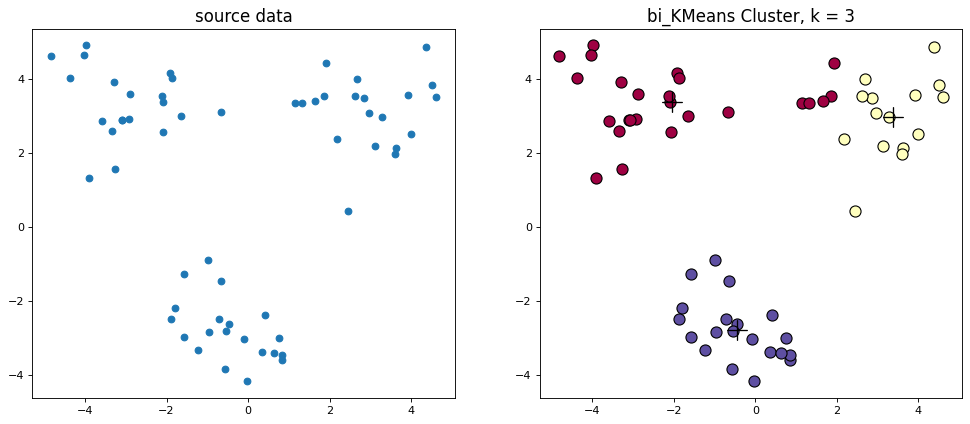

sb


In [802]:
def fileInput(filename, columnNum):
    """
    @brief      read data from file
    @param      filename
    @param      columnNum: the range of columns to be read, start from 1
    @return     points_mat: [[position1], [position2], [position3], ... [positionN]]
    """   
    points_set = []

    with codecs.open(filename) as f:
        for line in f.readlines():
            linetmp = line.strip().split()[0:columnNum]
            #! map return a map object, 
            #! so we need to convert it to list or tuple by list(map()) or tuple(map())
            flisttmp = list(map(float, linetmp))
            points_set.append(flisttmp) 
    
    points_mat = mat(points_set)

    return points_mat


def centroid_gen(points_mat, k):
    """
    @brief      generate k centroids
    @param      points_set
    @param      k:          the number of centroids
    @return     centroids:  [[position1], [position2], [position3], ... [positionN]]
    """
    columnNum = shape(points_mat)[1]
    centroids = mat(zeros((k, columnNum)))

    for j in range(columnNum):
        mintmp = min(points_mat[:, j])
        maxtmp = max(points_mat[:, j])
        rangetmp = float(maxtmp - mintmp)
        centroids[:,j] = mat(mintmp + rangetmp * random.rand(k, 1))

    return centroids

def distance_Euclidean(vecA, vecB):
    """
    @brief      calculate the Euclidean distance between two vectors
    @param      vecA
    @param      vecB
    @return     the Euclidean distance
    """
    return sqrt(sum(power(vecA - vecB, 2)))

def k_means(points_mat, k, distance_calculation):
    """
    @brief      kMeans algorithm
    @param      points_mat:             The data matrix
    @param      k:                      num of cluster
    @param      distance_calculation:   The distance funtion
    @return     centroids
    @return     cluster_attribute:      [[cluster_index, distance**2], ...]
    """

    pointsNum = shape(points_mat)[0]

    cluster_attribute = mat(zeros((pointsNum, 2)))  # cluster index, distance

    #* Initialize the centroids

    cluster_num_change = True

    while cluster_num_change:
        cluster_num_change = False

        centroids = centroid_gen(points_mat, k)


        cluster_changed = True

        #* loop until the cluster is not changed
        while cluster_changed:
            cluster_changed = False

            #* assign each point to the nearest centroid
            for i in range(pointsNum):
                cluster_index = None
                min_dist = inf
                for j in range(k):
                    dist_tmp = eval(distance_calculation)(points_mat[i, :], centroids[j, :])
                    if dist_tmp < min_dist:
                        min_dist = dist_tmp
                        cluster_index = j
                
                #* judge if the cluster is changed
                if cluster_attribute[i, 0] != cluster_index:
                    cluster_changed = True

                cluster_attribute[i, :] = cluster_index, min_dist**2

            #* update the centroids, in the new clusters
            for j in range(k):
                pointstmp = points_mat[nonzero(cluster_attribute[:, 0] == j)[0]]
                centroids[j, :] = mean(pointstmp, axis = 0)

            #* check if the total number of clusters is less than k

            #!cluster_attribute[:,0].T.tolist()-> [[]]
            if len(set(cluster_attribute[:,0].T.tolist()[0])) != k:
                cluster_num_change = True

    return centroids, cluster_attribute

#! there is the case
#! that all the points are in one cluster
def bi_kmeans(points_mat, k, distance_calculation):

    centroids_bi = []
    pointsNum = shape(points_mat)[0]
    cluster_attribute = mat(zeros((pointsNum, 2)))  # cluster index, distance

    #* Initialize the centroids
    #! at first, only one centroid
    #! here the output of mean is a matrix, with two shells [[x,x]]
    centroids_bi.append(mean(points_mat, axis = 0).tolist()[0])

    #* Initialize the cluster attribute
    for i in range(pointsNum):
        cluster_attribute[i,1] = eval(distance_calculation)(centroids_bi[0], points_mat[i, :]) ** 2

    while len(centroids_bi) < k:
        lowest_sse = inf
        for i in range(len(centroids_bi)):
            points_mat_tmp = points_mat[nonzero(cluster_attribute[:, 0] == i)[0],:]
            #* there are two clusters, index0 and index1
            centroids_bi_tmp, cluster_attribute_tmp = k_means(points_mat_tmp, 2, distance_calculation)
            sse_split = sum(cluster_attribute_tmp[:, 1])
            #! only calculate in the new cluster
            sse_nonsplit = sum(cluster_attribute[nonzero(cluster_attribute[:, 0] != i)[0], 1])

            #* find the BEST split in all cluster and ONLY choose one in each loop
            if sse_split + sse_nonsplit < lowest_sse:
                best_split_index = i
                lowest_sse = sse_split + sse_nonsplit
                best_cluster_attribute = cluster_attribute_tmp.copy()
                best_centroids_bi = centroids_bi_tmp.copy()

        #! for the split of cluster i
        #! i -> index 0, and len -> index 1 
        
        best_cluster_attribute[nonzero(best_cluster_attribute[:,0]==1)[0],0] = len(centroids_bi)
        best_cluster_attribute[nonzero(best_cluster_attribute[:,0]==0)[0],0] = best_split_index
        
        cluster_attribute[nonzero(cluster_attribute[:,0]==best_split_index)[0],:] = best_cluster_attribute

        centroids_bi[best_split_index] = best_centroids_bi[0,:].tolist()[0]
        centroids_bi.append(best_centroids_bi[1,:].tolist()[0])

    
    centroids_bi = mat(centroids_bi)
    
    return centroids_bi, cluster_attribute
                

                
            
def bi_kMeans(data_mat, k, dist):
	"""
	@brief      kMeans algorithm
	@param      data_mat     The data matrix
	@param      k            num of cluster
	@param      dist         The distance funtion
	@return     the cluster
	"""
	m = shape(data_mat)[0]

	# 初始化点的簇
	cluster_assment = mat(zeros((m, 2)))  # 类别，距离

	# 初始化聚类初始点
	centroid0 = mean(data_mat, axis = 0).tolist()[0]
	cent_list = [centroid0]
	print(cent_list)

	# 初始化SSE
	for j in range(m):
		cluster_assment[j, 1] = eval(dist)(mat(centroid0), data_mat[j, :]) ** 2 

	while (len(cent_list) < k):
		lowest_sse = inf 
		for i in range(len(cent_list)):
			# 尝试在每一类簇中进行k=2的kmeans划分
			ptsin_cur_cluster = data_mat[nonzero(cluster_assment[:, 0].A == i)[0],:]
			centroid_mat, split_cluster_ass = k_means(ptsin_cur_cluster,2, dist)
			# 计算分类之后的SSE值
			sse_split = sum(split_cluster_ass[:, 1])
			sse_nonsplit = sum(cluster_assment[nonzero(cluster_assment[:, 0].A != i)[0], 1])
			print("sse_split, sse_nonsplit", sse_split, sse_nonsplit)
			# 记录最好的划分位置
			if sse_split + sse_nonsplit < lowest_sse:
				best_cent_tosplit = i
				best_new_cents = centroid_mat
				best_cluster_ass = split_cluster_ass.copy()
				lowest_sse = sse_split + sse_nonsplit
		print( 'the bestCentToSplit is: ', best_cent_tosplit)
		print ('the len of bestClustAss is: ', len(best_cluster_ass))
		# 更新簇的分配结果
		best_cluster_ass[nonzero(best_cluster_ass[:, 0].A == 1)[0], 0] = len(cent_list)
		best_cluster_ass[nonzero(best_cluster_ass[:, 0].A == 0)[0], 0] = best_cent_tosplit
		cent_list[best_cent_tosplit] = best_new_cents[0, :].tolist()[0]
		cent_list.append(best_new_cents[1, :].tolist()[0])
		cluster_assment[nonzero(cluster_assment[:, 0].A == best_cent_tosplit)[0],:] = best_cluster_ass
	return mat(cent_list), cluster_assment
    
            

        


distance_calculation = "distance_Euclidean"
filename = "testSet2_kmeans.txt"
columnNum = 2
k = 3

points_mat = fileInput(filename, columnNum)

centroids_bi, cluster_attribute = bi_kmeans(points_mat, k, distance_calculation)
plot_cluster(points_mat, cluster_attribute, centroids_bi)

print("sb")







